# Initialization

Equation definitions, making the network, probabilities, etc.


In [1]:
from brian2 import *
from scipy.signal import welch
from scipy.integrate import simpson
from matplotlib import ticker

from ModelFiles.equations import *
from ModelFiles.functions import *
from ModelFiles.global_parameters import *

In [ ]:
def my_FR(spikes: np.ndarray,
            duration: int,
            window_size: float,
            overlap: float) -> (np.ndarray, np.ndarray):
    """
    Compute the firing rate using a windowed moving average.

    Parameters
    ----------
    spikes: numpy.ndarray
        The spike times (*not* Brian2 format, in -unitless- seconds)
    duration: int
        The duration of the recording (in -unitless- seconds)
    window_size: float
        Width of the moving average window (in -unitless- seconds)
    overlap: float
        Desired overlap between the windows (percentage in [0., 1.))

    Returns
    -------
    t: numpy.ndarray
        Array of time values for the computed firing rate. These are the window centers.
    FR: numpy.ndarray
        Spikes per window (needs to be normalized)
    """

    # Calculate new sampling times
    win_step = window_size * round(1. - overlap, 4)
    # fs_n = int(1/win_step)

    # First center is at the middle of the first window
    c0 = window_size/2
    cN = duration-c0

    # centers
    centers = np.arange(c0, cN+win_step, win_step)

    # Calculate windowed FR
    counts = []
    for center in centers:
        cl = center - c0
        ch = center + c0
        spike_cnt = np.count_nonzero(np.where((spikes >= cl) & (spikes < ch)))
        counts.append(spike_cnt)

    # return centers and spike counts per window
    return centers, np.array(counts)


In [2]:
""" Simulation parameters and inputs """
duration = 5*second
dt_sim = defaultclock.dt
ftheta = 6*Hz

# Connection probabilities
p_all = [0., 0.3, 0.3, 0.7]    # E->E, E->I, I->E, I->I
# p_all = [0., 0.5, 0.5, 0.5]    # E->E, E->I, I->E, I->I

# Folders
spikedir = 'spikes_Amelie_v2_5nA'
figdir = 'figs_Amelie_v2_5nA'

# Populations
N_E = 1000
N_I = 100

# Time vector
tv = arange(0, duration, dt_sim)

# Inputs
tonic_input = 0.1
stim_input = 8.
inputs_drive = TimedArray(0.*sin(2*pi*ftheta*tv)*nA, dt=defaultclock.dt)
inputs_stim = TimedArray(np.array([0]*400 + [stim_input]*2 + [0])*nA, dt=1*ms)
inputs_tonic = TimedArray(([0.] + [tonic_input]*10 + [0.])*nA, dt=1.*second)

In [3]:
# Excitatory
G_E = NeuronGroup(N=N_E,
    model=py_CAN_inp_eqs,
    threshold='v>V_th',
    # reset=reset_eqs,
    reset=reset_eqs_noCl,
    refractory=refractory_time,
    method=integ_method,
    name='CA1_pyCAN')
G_E.size = cell_size_py
G_E.glu = 1
G_E.v = -60*mV
G_E.r_drive = 0
G_E.rin = 0
G_E.r = 0

# Inhibitory
G_I = NeuronGroup(N=N_I,
    model=inh_inp_eqs,
    threshold='v>V_th',
    refractory=refractory_time,
    method=integ_method,
    name='CA1_inh')
G_I.size = cell_size_inh
G_I.v = -60*mV
G_I.r_drive = 0
G_I.rin = 0
G_I.r = 0

In [4]:
# Synapse creation
syn_EE = Synapses(G_E, G_E, on_pre="he_post+="+str(gains_all[3][0])+"*"+str(g_max_e/psiemens)+"*psiemens*glu_pre", name=G_E.name+"to"+G_E.name) # create synapse
syn_EI = Synapses(G_E, G_I, on_pre="he_post+="+str(gains_all[3][0])+"*"+str(g_max_e/psiemens)+"*psiemens*glu_pre", name=G_E.name+"to"+G_I.name) # create the excitatory synapse on the inhibitory population
syn_IE = Synapses(G_I, G_E, on_pre="hi_post+="+str(gains_all[3][1])+"*"+str(g_max_i/psiemens)+"*psiemens", name=G_I.name+"to"+G_E.name) # create the inhibitory synapse on the excitatory population
syn_II = Synapses(G_I, G_I, on_pre="hi_post+="+str(gains_all[3][1])+"*"+str(g_max_i/psiemens)+"*psiemens", name=G_I.name+"to"+G_I.name)

# Synapse connections
syn_EE.connect(condition='i!=j', p=p_all[0]) # connect E2E
syn_EI.connect(p=p_all[1]) # connect E2I
syn_IE.connect(p=p_all[2]) # connect I2E
syn_II.connect(condition='i!=j', p=p_all[3]) # connect I2I

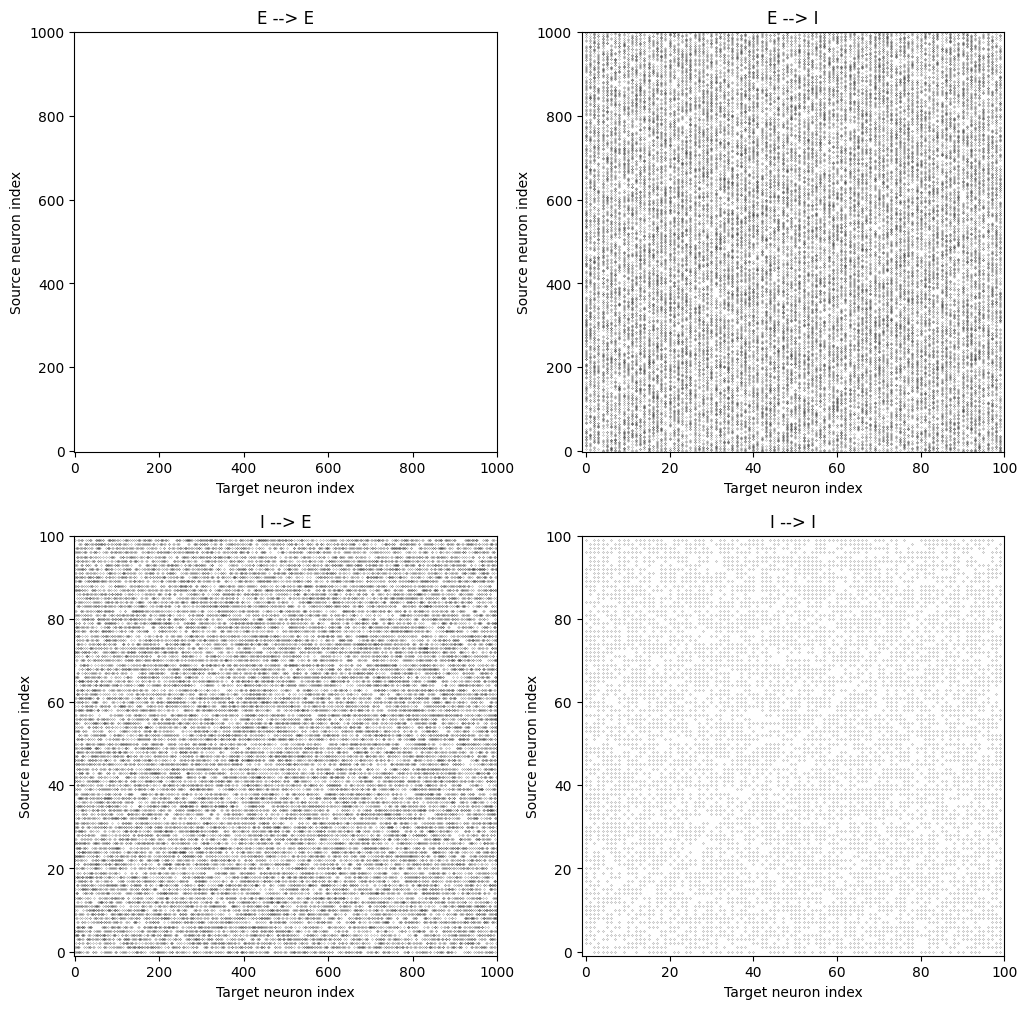

In [5]:
# Make the 2x2 figure for synapse plotting
fig,axs = subplots(2,2, figsize=(12,12))

marksize = 0.15

# E->E
Ns = len(syn_EE.source)
Nt = len(syn_EE.target)
im1 = np.zeros((Ns,Nt))
im1[syn_EE.i,syn_EE.j] = 1

axs[0,0].plot(syn_EE.j, syn_EE.i, 'ok', markersize=marksize)
axs[0,0].set_ylim(-1, len(syn_EE.source))
axs[0,0].set_xlim(-1, len(syn_EE.target))
axs[0,0].set_ylabel('Source neuron index')
axs[0,0].set_xlabel('Target neuron index')
axs[0,0].set_title('E --> E')

# E->I
Ns = len(syn_EI.source)
Nt = len(syn_EI.target)
im2 = np.zeros((Ns,Nt))
im2[syn_EI.i,syn_EI.j] = 1

axs[0,1].plot(syn_EI.j, syn_EI.i, 'ok', markersize=marksize)
axs[0,1].set_ylim(-1, len(syn_EI.source))
axs[0,1].set_xlim(-1, len(syn_EI.target))
axs[0,1].set_ylabel('Source neuron index')
axs[0,1].set_xlabel('Target neuron index')
axs[0,1].set_title('E --> I')

# I->E
Ns = len(syn_IE.source)
Nt = len(syn_IE.target)
im3 = np.zeros((Ns,Nt))
im3[syn_IE.i,syn_IE.j] = 1

axs[1,0].plot(syn_IE.j, syn_IE.i, 'ok', markersize=marksize)
axs[1,0].set_ylim(-1, len(syn_IE.source))
axs[1,0].set_xlim(-1, len(syn_IE.target))
axs[1,0].set_ylabel('Source neuron index')
axs[1,0].set_xlabel('Target neuron index')
axs[1,0].set_title('I --> E')

# I->I
Ns = len(syn_II.source)
Nt = len(syn_II.target)
im4 = np.zeros((Ns,Nt))
im4[syn_II.i,syn_II.j] = 1

axs[1,1].plot(syn_II.j, syn_II.i, 'ok', markersize=marksize)
axs[1,1].set_ylim(-1, len(syn_II.source))
axs[1,1].set_xlim(-1, len(syn_II.target))
axs[1,1].set_ylabel('Source neuron index')
axs[1,1].set_xlabel('Target neuron index')
axs[1,1].set_title('I --> I')

plt.show()

In [6]:
# One unit to get the summed Vm for E and one for I units
G_Vm_sumE = NeuronGroup(1, eq_record_neurons, name='Vm_sum_E')
G_Vm_sumI = NeuronGroup(1, eq_record_neurons, name='Vm_sum_I')

Syn_Vm_E = Synapses(G_E, G_Vm_sumE, model=eq_record_synapses)
Syn_Vm_E.connect()

Syn_Vm_I = Synapses(G_I, G_Vm_sumI, model=eq_record_synapses)
Syn_Vm_I.connect()

In [7]:
# One unit records both I_SynE and I_SynI
G_ISyn_sumE = NeuronGroup(1, eq_record_LFP_neurons, name='ISyn_sum_E')
G_ISyn_sumI = NeuronGroup(1, eq_record_LFP_neurons, name='ISyn_sum_I')

Syn_Isyn_E = Synapses(G_E, G_ISyn_sumE, model=eq_record_LFP_synapses)
Syn_Isyn_E.connect()

Syn_Isyn_I = Synapses(G_I, G_ISyn_sumI, model=eq_record_LFP_synapses)
Syn_Isyn_I.connect()

In [8]:
# Monitors
statemon_GE = StateMonitor(G_E, ['v', 'I_SynE', 'I_SynI'], record=True, name='Statemon_E')
statemon_GI = StateMonitor(G_I, ['v', 'I_SynE', 'I_SynI'], record=True, name='Statemon_I')

spikemon_GE = SpikeMonitor(G_E, name='Spikes_E')
spikemon_GI = SpikeMonitor(G_I, name='Spikes_I')

statemon_Vm_avg_GE = StateMonitor(G_Vm_sumE, ['sum_v'], record=True, name='Statemon_Vm_E')
statemon_Vm_avg_GI = StateMonitor(G_Vm_sumI, ['sum_v'], record=True, name='Statemon_Vm_I')

statemon_ISyn_GE = StateMonitor(G_ISyn_sumE, ['sum_I_SynE', 'sum_I_SynI'], record=True, name='Statemon_syncurr_E')
statemon_ISyn_GI = StateMonitor(G_ISyn_sumI, ['sum_I_SynE', 'sum_I_SynI'], record=True, name='Statemon_syncurr_I')

In [9]:
# Network
net = Network()

# Add groups
net.add(G_E, G_I)
net.add(G_Vm_sumE, G_Vm_sumI) 
net.add(G_ISyn_sumE, G_ISyn_sumI)

# Add synapses
net.add(syn_EE, syn_EI, syn_IE, syn_II)
net.add(Syn_Vm_E, Syn_Vm_I)
net.add(Syn_Isyn_E, Syn_Isyn_I)

# Add monitors
net.add(statemon_GE, statemon_GI)
net.add(spikemon_GE, spikemon_GI)
net.add(statemon_Vm_avg_GE, statemon_Vm_avg_GI)
net.add(statemon_ISyn_GE, statemon_ISyn_GI)

In [10]:
# Initial conditions (fixed)
Vm_E_init = (-60 + 10*randn(N_E))*mV
Vm_I_init = (-60 + 10*randn(N_I))*mV

In [11]:
# Disable the ramp input
G_E.r_drive = 0
G_I.r_drive = 0

# Disable tonic input
G_E.rin = 0
G_I.rin = 0

# Disable stim input
G_E.r = 0
G_I.r = 0

In [12]:
# Store a snapshot of the network
net.store('initialized')

# Simulate stimulation at different frequencies

We stimulate at frequencies up to 80 Hz and test the network's power ratio between theta/gamma bands.

In [13]:
# Scipy and filtering 
import scipy.signal as sig

# Simulation-Stimulation parameters
duration = 12 # seconds
dt = 1e-4 # seconds
fs = 1/dt # Hz
stim_onset = 1 # seconds
I_stim = 5 # nA
pw = [1.0e-3] # Pulse width, sec
pf = 1000 # Pulse freq, Hz
ipi = .1e-3 # Inter-pulse interval, sec

# Where to stim?
stim_E = True
stim_I = False

# Enable tonic input?
tonic_E = False
tonic_I = False

# Define tonic input
tonic_input = 0.8
inputs_tonic = TimedArray(([0.] + [tonic_input]*15 + [0.])*nA, dt=1.*second)

In [14]:
# Filtering parameters
theta_freqs = [6, 10] # Hz
gamma_freqs = [40, 60] # Hz

fp = theta_freqs
fc = [4, 12]
passband_ripple = 3 # 3dB ripple
stopband_attenuation = 60 # 60dB attenuation of stopband

Nt, Wnt = sig.buttord(fp, fc, passband_ripple, stopband_attenuation, False, fs=fs)
print("Theta: ", Nt, Wnt)

fp = gamma_freqs
fc = [30, 80]

Ng, Wng = sig.buttord(fp, fc, passband_ripple, stopband_attenuation, False, fs=fs)
print("Gamma: ", Ng, Wng)

Theta:  13 [ 5.999726   10.00045668]
Gamma:  8 [39.99762514 60.00356204]


In [15]:
# Set the filter parameters properly
filtord = 13

# Create the filters
sos_theta = sig.butter(N=max(Nt,Ng), Wn=Wnt, btype='bandpass', analog=False, output='sos', fs=fs)
sos_gamma = sig.butter(N=max(Nt,Ng), Wn=Wng, btype='bandpass', analog=False, output='sos', fs=fs)

WARNING    /home/nikos/miniconda3/envs/brianenv2/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: divide by zero encountered in log10
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]
WARNING    /home/nikos/miniconda3/envs/brianenv2/lib/python3.9/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: divide by zero encountered in log10
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]


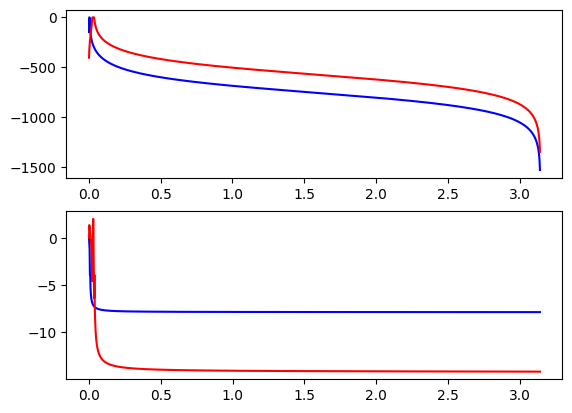

In [16]:
fig,axs = plt.subplots(2,1)

wt,ht = sig.sosfreqz(sos_theta, worN=1500)
axs[0].plot(wt, 20 * np.log10(abs(ht)), 'b')
axs[1].plot(wt, np.unwrap(np.angle(ht)), 'b')

wg,hg = sig.sosfreqz(sos_gamma, worN=1500)
axs[0].plot(wg, 20 * np.log10(abs(hg)), 'r')
axs[1].plot(wg, np.unwrap(np.angle(hg)), 'r')

plt.show()

In [17]:
stim_freqs = np.arange(1,81)
for stim_freq in [5]:
    
    # Restore the network
    net.restore('initialized')
    
    # Enable stim input on population X
    if stim_E:
        print("Stim @ E: on")
        G_E.r = 1
    
    if stim_I:
        print("Stim @ I: on")
        G_I.r = 1
    
    # Number of pulses
    nr_of_pulses = (duration - stim_onset) * stim_freq

    
    xstim, tv = generate_stim(duration=duration, dt=dt, 
                          stim_on=stim_onset,
                          I_stim=[I_stim],
                          nr_of_trains= (duration - stim_onset) * stim_freq, 
                          nr_of_pulses=1,
                          stim_freq=stim_freq,
                          pulse_width=pw, pulse_freq=pf, ipi=ipi)

    inputs_stim = TimedArray(xstim*nA, dt=dt*second)
    TYN γιατί μετά από όσα είχα κάνει γι’αυτόν αποφάσισα να του μιλήσω ξεκάθαρα και να του πω το πως νιώθω …και η απάντηση του ήταν ένα απλό 
    # Run the simulation
    net.run(duration*second, report='text', report_period=5*second)

Stim @ E: on
Starting simulation at t=0. s for a duration of 12. s
1.2547 s (10%) simulated in 5s, estimated 43s remaining.
2.4765 s (20%) simulated in 10s, estimated 38s remaining.
3.716 s (30%) simulated in 15s, estimated 33s remaining.
5.0104 s (41%) simulated in 20s, estimated 28s remaining.
6.3232 s (52%) simulated in 25s, estimated 22s remaining.
7.4624 s (62%) simulated in 30s, estimated 18s remaining.
8.7775 s (73%) simulated in 35s, estimated 13s remaining.
10.0755 s (83%) simulated in 40s, estimated 8s remaining.
11.3697 s (94%) simulated in 45s, estimated 2s remaining.
12. s (100%) simulated in 47s


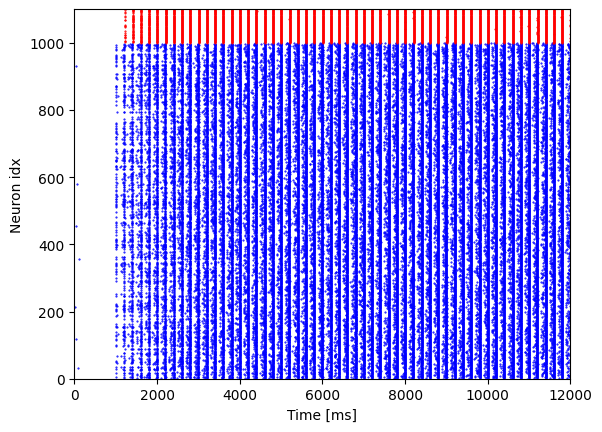

In [18]:
plt.plot(spikemon_GE.t/ms, spikemon_GE.i, 'b.', markersize=1)
plt.plot(spikemon_GI.t/ms, spikemon_GI.i+N_E, 'r.', markersize=1)
plt.xlabel('Time [ms]')
plt.ylabel('Neuron idx')
plt.xlim([0,duration*second/ms])
plt.ylim([0, N_E+N_I])
plt.show()

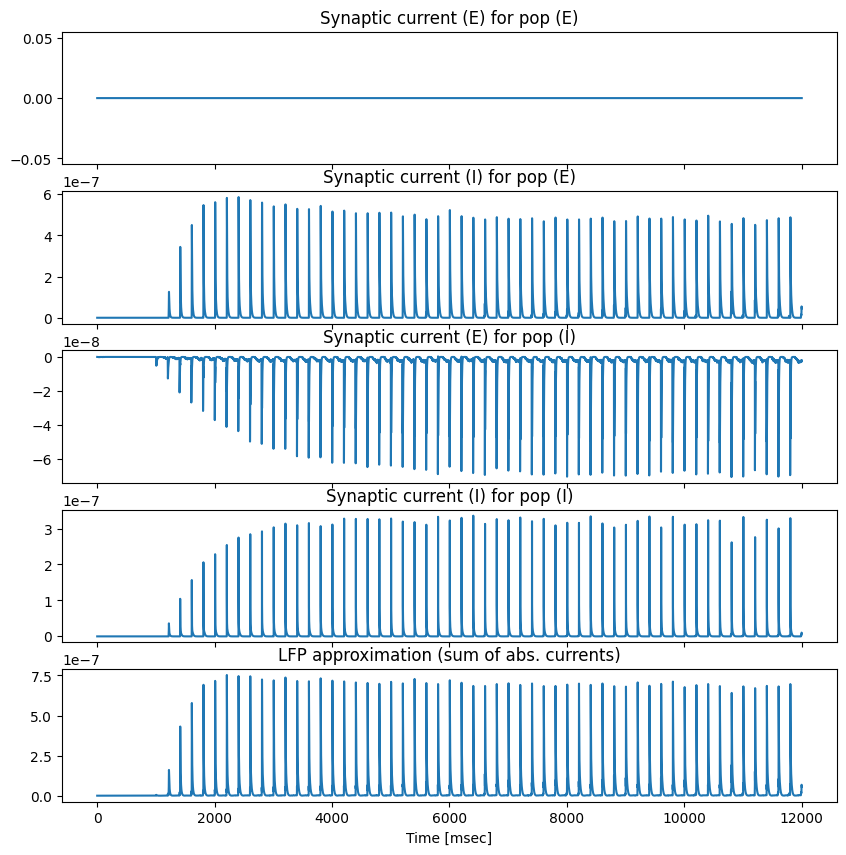

In [19]:
fig,axs = plt.subplots(5,1, figsize=(10,10), sharex=True)

axs[0].plot(statemon_ISyn_GE.t/ms, statemon_ISyn_GE.sum_I_SynE[0])
axs[1].plot(statemon_ISyn_GE.t/ms, statemon_ISyn_GE.sum_I_SynI[0])
axs[2].plot(statemon_ISyn_GI.t/ms, statemon_ISyn_GI.sum_I_SynE[0])
axs[3].plot(statemon_ISyn_GI.t/ms, statemon_ISyn_GI.sum_I_SynI[0])
axs[4].plot(statemon_ISyn_GI.t/ms, (np.abs(statemon_ISyn_GE.sum_I_SynE[0]) +
                              np.abs(statemon_ISyn_GE.sum_I_SynI[0]) +
                              np.abs(statemon_ISyn_GI.sum_I_SynE[0]) +
                              np.abs(statemon_ISyn_GI.sum_I_SynI[0])))

axs[0].set_title('Synaptic current (E) for pop (E)')
axs[1].set_title('Synaptic current (I) for pop (E)')
axs[2].set_title('Synaptic current (E) for pop (I)')
axs[3].set_title('Synaptic current (I) for pop (I)')
axs[4].set_title('LFP approximation (sum of abs. currents)')

axs[4].set_xlabel('Time [msec]')

plt.show()

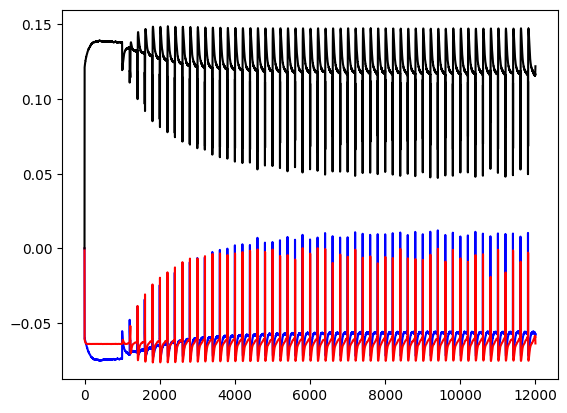

In [20]:
plt.plot(statemon_Vm_avg_GE.t/ms, statemon_Vm_avg_GE.sum_v[0], 'b')
plt.plot(statemon_Vm_avg_GI.t/ms, statemon_Vm_avg_GI.sum_v[0], 'r')
plt.plot(statemon_Vm_avg_GE.t/ms, np.abs(statemon_Vm_avg_GE.sum_v[0] + statemon_Vm_avg_GI.sum_v[0]), 'k')
plt.show()


# PSD of FRs

Good enough proxy, and can be plotted as an image.

# Rasters

Both tonic and osc. inputs (separately), coupled and with noise

Stimulation at 10,20,30...200 Hz

No input to the E when stimulation them

In [24]:
# Simulate or load?
simulate = True

In [25]:
# Define the range of stimulations
fstims_all = np.arange(0,201,10)
fstims_all[0] = 1 # first value cannot be zero

# Do we simulate or load?
if simulate:
    stim_data = []
    rasters_all = []

    # Test this noise
    sigma_noise_inh = 200.*uvolt
    sigma_noise_exc = 2000.*uvolt

    # Run the simulations
    for idx, stim_freq in enumerate(fstims_all):

        # Restore the network
        net.restore('initialized')

        # Initial values
        G_E.v = Vm_E_init
        G_I.v = Vm_I_init

        # Enable stim input on population X
        if stim_E:
            print("Stim @ E: on")
            G_E.r = 1

        if stim_I:
            print("Stim @ I: on")
            G_I.r = 1
            
        # Enable tonic input on population X
        if tonic_E:
            print("Tonic input @ E: on")
            G_E.rin = 1
        
        if tonic_I:
            print("Tonic input @ I: on")
            G_I.rin = 1

        # Print someI_stimrmation
        print(f"I_stim: {I_stim}nA | fstim: {stim_freq}Hz")

        # Number of pulses
        nr_of_pulses = (duration - stim_onset) * stim_freq

        # Generate stimulation waveform
        xstim, tv = generate_stim(duration=duration, dt=dt, 
                              stim_on=stim_onset,
                              I_stim=[I_stim],
                              nr_of_trains= (duration - stim_onset) * stim_freq, 
                              nr_of_pulses=1,
                              stim_freq=stim_freq,
                              pulse_width=pw, pulse_freq=pf, ipi=ipi)

        inputs_stim = TimedArray(xstim*nA, dt=dt*second)

        # Save the stim data
        stim_data += [[tv, xstim]]

        # Run the simulation
        net.run(duration*second, report='text', report_period=5*second)

        # Store the rasters
        rasters_all += [[[np.copy(spikemon_GE.t/ms)*ms, np.copy(spikemon_GE.i)], [np.copy(spikemon_GI.t/ms)*ms, np.copy(spikemon_GI.i)]]]

        # Save the spike data
        # E
        np.savetxt(f'data/StimOpto/{spikedir}/{idx}_{spikemon_GE.name}_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_i.txt', np.array(spikemon_GE.i).astype(np.int16), fmt='%d')
        np.savetxt(f'data/StimOpto/{spikedir}/{idx}_{spikemon_GE.name}_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_t.txt', np.array(spikemon_GE.t/ms).astype(np.float32), fmt='%.1f')

        # I
        np.savetxt(f'data/StimOpto/{spikedir}/{idx}_{spikemon_GI.name}_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_i.txt', np.array(spikemon_GI.i).astype(np.int16), fmt='%d')
        np.savetxt(f'data/StimOpto/{spikedir}/{idx}_{spikemon_GI.name}_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_t.txt', np.array(spikemon_GI.t/ms).astype(np.float32), fmt='%.1f')

    # Are we done?
    print('Done')
    
else:
    print("Loading data")
    rasters_all = []
    stim_data = []
    
    # Load the data
    for idx, stim_freq in enumerate(fstims_all):
        
        # Print someI_stimrmation
        print(f"I_stim: {I_stim}nA | fstim: {stim_freq}Hz")

        # Number of pulses
        nr_of_pulses = (duration - stim_onset) * stim_freq

        # Generate stimulation waveform
        xstim, tv = generate_stim(duration=duration, dt=dt, 
                              stim_on=stim_onset,
                              I_stim=[I_stim],
                              nr_of_trains= (duration - stim_onset) * stim_freq, 
                              nr_of_pulses=1,
                              stim_freq=stim_freq,
                              pulse_width=pw, pulse_freq=pf, ipi=ipi)

        inputs_stim = TimedArray(xstim*nA, dt=dt*second)

        # Save the stim data
        stim_data += [[tv, xstim]]

        # Load the spike data
        # E
        iE = np.loadtxt(f'data/StimOpto/{spikedir}/{idx}_Spikes_E_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_i.txt')
        tE = np.loadtxt(f'data/StimOpto/{spikedir}/{idx}_Spikes_E_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_t.txt')

        # I
        iI = np.loadtxt(f'data/StimOpto/{spikedir}/{idx}_Spikes_I_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_i.txt')
        tI = np.loadtxt(f'data/StimOpto/{spikedir}/{idx}_Spikes_I_fstim_{stim_freq}Hz_Istim_{I_stim}nA_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_ICAN_on_t.txt')

        rasters_all += [[[np.copy(tE)*ms, np.copy(iE.astype(int))], [np.copy(tI)*ms, np.copy(iI.astype(int))]]]
        

Stim @ E: on
I_stim: 5nA | fstim: 1Hz
Starting simulation at t=0. s for a duration of 12. s
1.2603 s (10%) simulated in 5s, estimated 43s remaining.
2.551 s (21%) simulated in 10s, estimated 37s remaining.
3.8441 s (32%) simulated in 15s, estimated 32s remaining.
5.1495 s (42%) simulated in 20s, estimated 27s remaining.
6.4543 s (53%) simulated in 25s, estimated 21s remaining.
7.7609 s (64%) simulated in 30s, estimated 16s remaining.
9.0672 s (75%) simulated in 35s, estimated 11s remaining.
10.3742 s (86%) simulated in 40s, estimated 6s remaining.
11.6835 s (97%) simulated in 45s, estimated 1s remaining.
12. s (100%) simulated in 46s
Stim @ E: on
I_stim: 5nA | fstim: 10Hz
Starting simulation at t=0. s for a duration of 12. s
1.3153 s (10%) simulated in 5s, estimated 41s remaining.
2.6373 s (21%) simulated in 10s, estimated 36s remaining.
3.9712 s (33%) simulated in 15s, estimated 30s remaining.
5.318 s (44%) simulated in 20s, estimated 25s remaining.
6.6768 s (55%) simulated in 25s, es

In [26]:
# Parameters for FRs
window_size = 1*ms
bin_num = int(duration/window_size)
fs_FR = 1/window_size

# Parameters for Pxxs
win_len = 1*second;
nperseg = int(win_len/second * fs_FR/Hz)
overlap_PSD = 0.99
NFFT = 2**((nperseg-1).bit_length()+1) # np.ceil(np.log2(window_width))
NFFT = nperseg

# Calculate the FRs and the Pxxs from the rasters
FRs_all = []
Pxxs_all = []
for idx, stim_freq in enumerate(fstims_all):
    # Current stim
    tv, xstim = stim_data[idx]
    
    # Current rasters
    tE, iE = rasters_all[idx][0]
    tI, iI = rasters_all[idx][1]
    
    # Calculate the FRs
    FR_E, tv_E = np.histogram(tE/second, bins=bin_num, range=[0,duration])
    FR_I, tv_I = np.histogram(tI/second, bins=bin_num, range=[0,duration])
    
    # Time vector adjustment
    tv_E = tv_E[0:-1] + (window_size/2/second)
    tv_I = tv_I[0:-1] + (window_size/2/second)

    # Save the FRs
    FRs_all += [[[tv_E, FR_E], [tv_I, FR_I]]]

    # Calculate the Pxxs
    (f_E, PSD_E) = welch(FR_E, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
    (f_I, PSD_I) = welch(FR_I, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
    
    # Save the Pxxs
    Pxxs_all += [[[f_E, PSD_E], [f_I, PSD_I]]]

    # Make and save a plot
    fig,axs = plt.subplots(4,1, figsize=(12,18))

    # Stim
    axs[0].plot(tv, xstim)
    axs[0].set_xlim([0,duration/second])
    axs[0].set_title('Stimulation waveform')
    axs[0].set_ylabel('Injected current [nA]')
    
    # Rasters
    axs[1].plot(tE, iE, 'b.', markersize=1)
    axs[1].plot(tI, iI+N_E, 'r.', markersize=1)
    axs[1].set_xlim([0, duration/second])
    axs[1].set_ylim([0,N_I+N_E])
    axs[1].set_title('Rasters')
    axs[1].set_ylabel('Neuron idx')


    # FRs
    axs[2].plot(tv_E, FR_E/N_E, 'b')
    axs[2].plot(tv_I, FR_I/N_I + 1, 'r-')
    axs[2].set_title('Firing Rates (normalized)')
    axs[2].set_ylabel('Spikes/sec (norm.) [Hz]')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_xlim([0, duration/second])

    # Pxxs
    axs[3].plot(f_E, PSD_E, 'b')
    axs[3].plot(f_I, PSD_I, 'r')
    axs[3].set_xlim([0,200])
    axs[3].set_title('PSD')
    axs[3].set_xlabel('Frequency [Hz]')

    # Save the figure
    fig.suptitle(f'{idx}: Stimulation frequency {stim_freq} Hz', x=0.1, y=0.99, horizontalalignment='left', verticalalignment='top')
    plt.tight_layout()
    plt.savefig(f'figures/StimOpto/{figdir}/{idx}_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_Istim_{I_stim}nA_tonic_{tonic_input}nA_fstim_{stim_freq}Hz_ICAN_on' + '.png')
    # plt.show()
    plt.close()

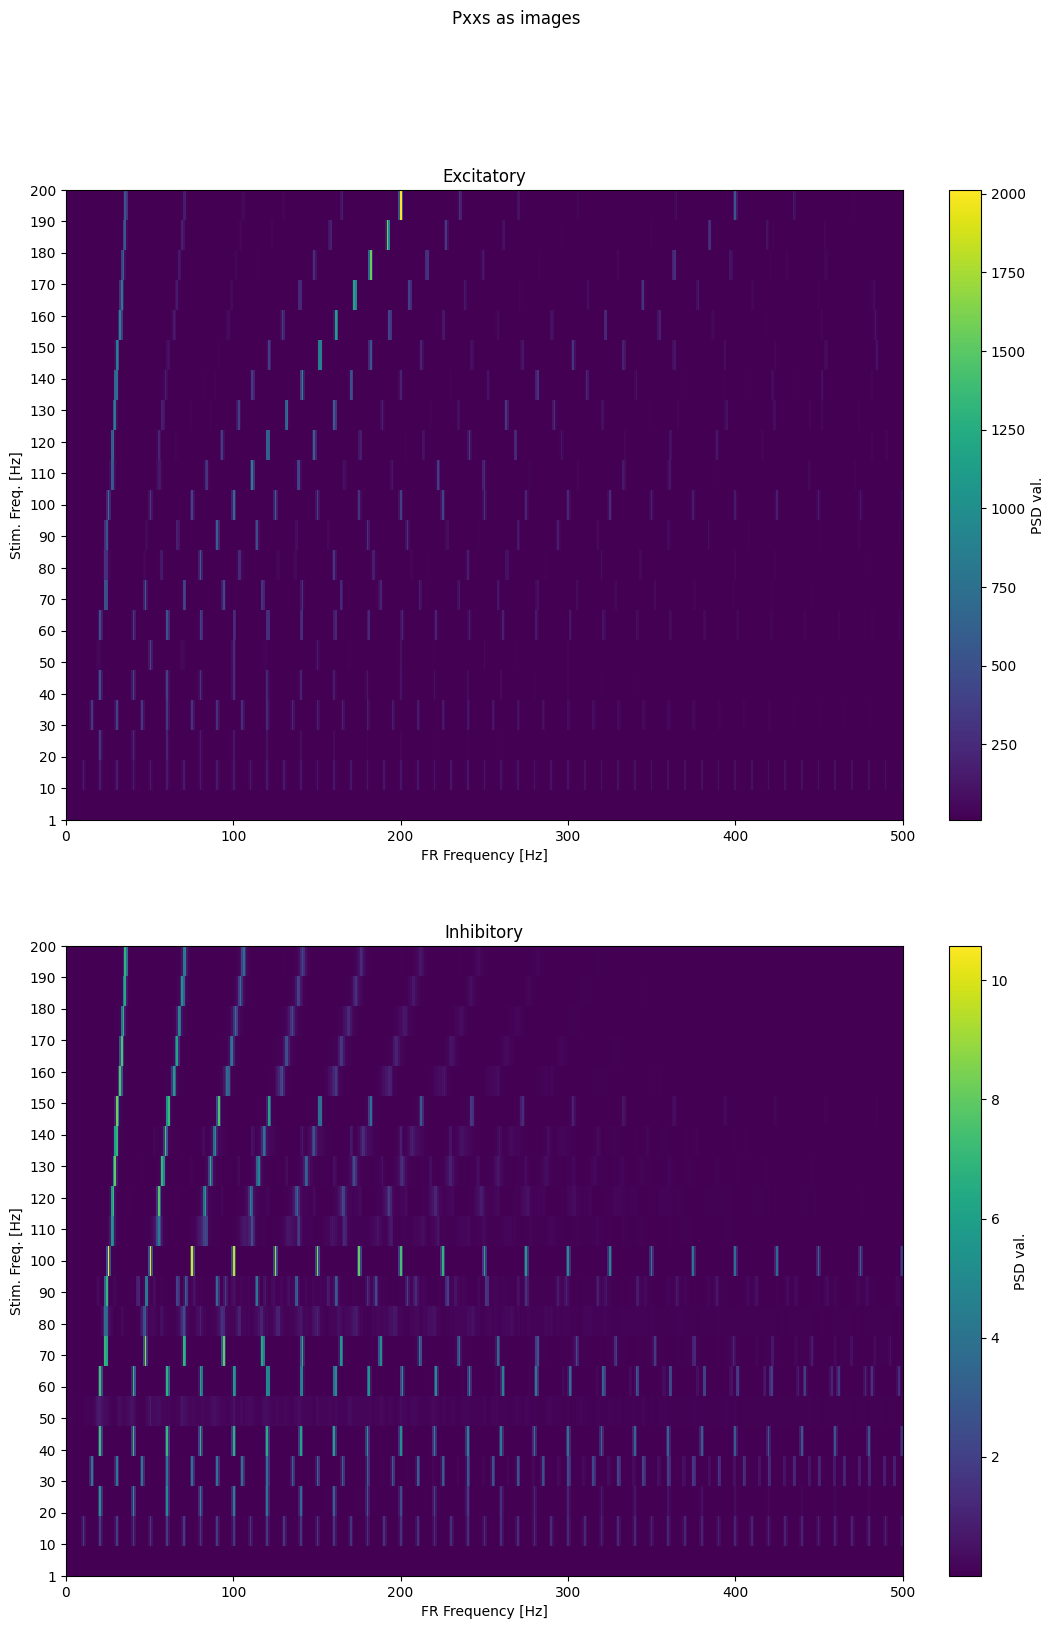

In [27]:
# Make a figure with the stimulation vs frequency modulation in theta-gamma ranges

# Pxxs as an image -> Make a 2D array with the Pxxs of E/I populations and use imshow to view it

fv = Pxxs_all[0][0][0]
img_E = np.zeros((len(Pxxs_all),len(fv)))
img_I = np.zeros((len(Pxxs_all),len(fv)))
for idx, Pxxs in enumerate(Pxxs_all):
    img_E += [Pxxs[0][1]]
    img_I += [Pxxs[1][1]]


img_E1 = np.array(img_E)
img_I1 = np.array(img_I)

img_E1 = np.array(Pxxs_all)[:,0,1,:]
img_I1 = np.array(Pxxs_all)[:,1,1,:]

zmin = min(np.max(img_E1), np.max(img_I1))
zmax = max(np.max(img_E1), np.max(img_I1))
fig,axs = plt.subplots(2,1,figsize=(12,18))
c_E = axs[0].imshow(img_E1,
           vmin=zmin,
           vmax=zmax,
           extent = [f_E.min(), f_E.max(),
                     0, idx],
           aspect='auto',
           interpolation='none',
           origin='lower')
axs[0].set_title('Excitatory')
axs[0].set_xlabel('FR Frequency [Hz]')
axs[0].set_ylabel('Stim. Freq. [Hz]')
axs[0].set_yticks(np.arange(0,idx+1))
axs[0].set_yticklabels([f"{f_stim}" for f_stim in fstims_all])

c_I = axs[1].imshow(img_I1,
           extent = [f_I.min(), f_I.max(),
                     0, idx],
           aspect='auto',
           interpolation='none',
           origin='lower')
axs[1].set_title('Inhibitory')
axs[1].set_xlabel('FR Frequency [Hz]')
axs[1].set_ylabel('Stim. Freq. [Hz]')
axs[1].set_yticks(np.arange(0,idx+1))
axs[1].set_yticklabels([f"{f_stim}" for f_stim in fstims_all])

fig.suptitle('Pxxs as images')
fig.colorbar(c_E, ax=axs[0], fraction=0.05, label='PSD val.')
fig.colorbar(c_I, ax=axs[1], fraction=0.05, label='PSD val.')


# Save the figure
plt.savefig(f'figures/StimOpto/{figdir}/Pxxs_imgs_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_GIstim_{I_stim}nA_tonic_{tonic_input}nA_fstim_{stim_freq}Hz_ICAN_on' + '.png')
plt.show()

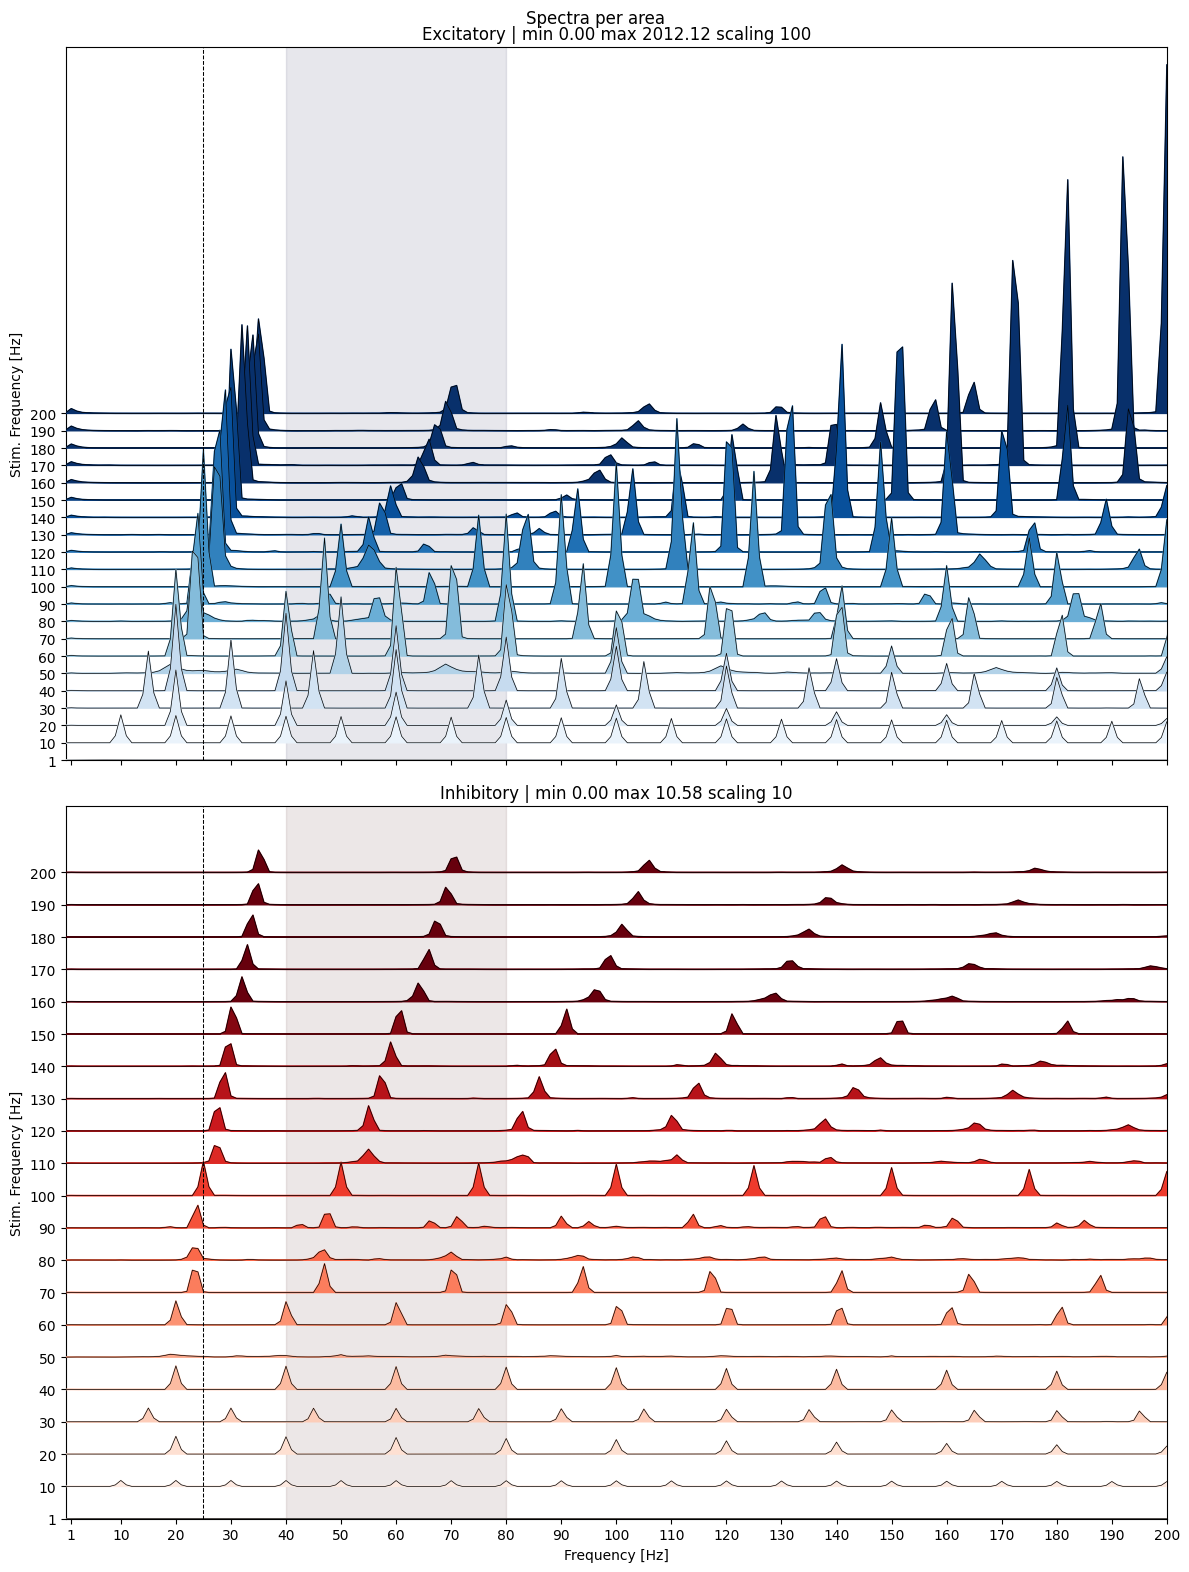

In [28]:
import matplotlib.cm as cm
cmapE = cm.get_cmap("Blues")
cmapI = cm.get_cmap("Reds")

# Make the figure
fig,axs = plt.subplots(2,1, figsize=(12,16), sharex=True)

# Pxxs array
Pxxs_arr = np.array(Pxxs_all)

# E
img_E1 = np.array(Pxxs_all)[:,0,1,:]
img_I1 = np.array(Pxxs_all)[:,1,1,:]

Pxxs_E = Pxxs_arr[:,0,1,:]
Pxxs_I = Pxxs_arr[:,1,1,:]
fv = Pxxs_arr[0,0,0,:]

scalingE = 100
scalingI = 10

for idx in range(0, len(Pxxs_all)):
    # Colormaps
    colorE = cmapE(idx*16 / 256)
    colorI = cmapI(idx*16 / 256)
    
    # E
    axs[0].plot(fv, Pxxs_E[idx]+idx*scalingE, color='k', linewidth=0.5, zorder=100 - idx)
    axs[0].fill_between(fv, Pxxs_E[idx]+idx*scalingE, idx*scalingE, color=colorE, zorder=100 - idx)

    # I    
    axs[1].plot(fv, Pxxs_I[idx]+idx*scalingI, color='k', linewidth=0.5, zorder=100 - idx)
    axs[1].fill_between(fv, Pxxs_I[idx]+idx*scalingI, idx*scalingI, color=colorI, zorder=100 - idx)


# Mark frequencies
freqs = [25]
gamma_freqs = [40, 60, 80]
for freq in freqs:
    axs[0].axvline(freq, ls="--", lw=0.75, color="black", zorder=250)
    axs[1].axvline(freq, ls="--", lw=0.75, color="black", zorder=250)

# Mark the gamma band
axs[0].fill_between([min(gamma_freqs),max(gamma_freqs)], 10e3, 0, color=[0.1, 0.1, 0.3, 0.1], zorder=-1)
axs[0].set_ylim([0, np.max(Pxxs_E)+(idx+1)*scalingE])
axs[0].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

axs[1].fill_between([40,80], 10e3, 0, color=[0.3, 0.1, 0.1, 0.1], zorder=-1)
axs[1].set_ylim([0, np.max(Pxxs_I)+(idx+1)*scalingI])

# Pretty stuff
axs[0].set_ylabel('Stim. Frequency [Hz]')
axs[0].yaxis.set_tick_params(labelleft=True)
axs[0].set_yticks(np.arange(0,(idx+1)*scalingE,scalingE))
axs[0].set_yticklabels([f"{f_stim}" for f_stim in fstims_all])
axs[0].set_xlim([0,200])

axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Stim. Frequency [Hz]')
axs[1].yaxis.set_tick_params(labelleft=True)
axs[1].set_yticks(np.arange(0,(idx+1)*scalingI,scalingI))
axs[1].set_yticklabels([f"{f_stim}" for f_stim in fstims_all])

# Titles
fig.suptitle('Spectra per area')
axs[0].set_title(f'Excitatory | min {Pxxs_E.min():.2f} max {Pxxs_E.max():.2f} scaling {scalingE}')
axs[1].set_title(f'Inhibitory | min {Pxxs_I.min():.2f} max {Pxxs_I.max():.2f} scaling {scalingI}')

# Tight layout
plt.tight_layout()
plt.savefig(f'figures/StimOpto/{figdir}/Pxxs_stacked_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_Istim_{I_stim}nA_tonic_{tonic_input}nA_fstim_{stim_freq}Hz_ICAN_on' + '.png')
plt.show()

# Relative power metrics (Cardin et al. 2009)

A direct quote from the methods section of the paper:

> For each stimulation frequency, we measured the relative power in an 8-Hz band centred on that frequency. \[...\] For each stimulation frequency, we measured the relative power
in an 8-Hz band centred on that frequency. We also measured the power ratio: P<sub>light</sub>/P<sub>baseline</sub>, where P<sub>light</sub> is the relative power in a frequency band in the presence of light stimulation and P<sub>baseline</sub> is the power in that band in the absence of light stimulation.

We will use a 5 Hz band around the stimulation frequency (i.e. stim @10 Hz means we compute the power between \[5,15\] Hz)

In [29]:
Pxxs_E = Pxxs_arr[:,0,1,:]
Pxxs_I = Pxxs_arr[:,1,1,:]
fv = Pxxs_arr[0,0,0,:]

# Find intersecting values in frequency vector
idx_theta = np.logical_and(fv >= 4, fv <= 12)

# Find the PSD peaks (max values)
idx_sim = 6
fidxE = np.argmax(Pxxs_E[idx_sim])
fidxI = np.argmax(Pxxs_I[idx_sim])

# Calculate band power
band_power_E = simpson(Pxxs_E[idx_sim][idx_theta], dx=fv[1]-fv[0])
band_power_I = simpson(Pxxs_I[idx_sim][idx_theta], dx=fv[1]-fv[0])
print("Band [5,15]Hz:", band_power_E, band_power_I)
print(f"Peak_E {Pxxs_E[idx_sim][fidxE]} at frequency {fv[fidxE]} Hz")
print(f"Peak_I {Pxxs_I[idx_sim][fidxI]} at frequency {fv[fidxI]} Hz")


Band [5,15]Hz: 0.613855934159484 0.007551709672667462
Peak_E 512.2666094699908 at frequency 60.0 Hz
Peak_I 7.401217012506569 at frequency 20.0 Hz


[-4.  6.]
Out of bounds, skipping!
[ 5. 15.]
[15. 25.]
[25. 35.]
[35. 45.]
[45. 55.]
[55. 65.]
[65. 75.]
[75. 85.]
[85. 95.]
[ 95. 105.]
[105. 115.]
[115. 125.]
[125. 135.]
[135. 145.]
[145. 155.]
[155. 165.]
[165. 175.]
[175. 185.]
[185. 195.]
[195. 205.]


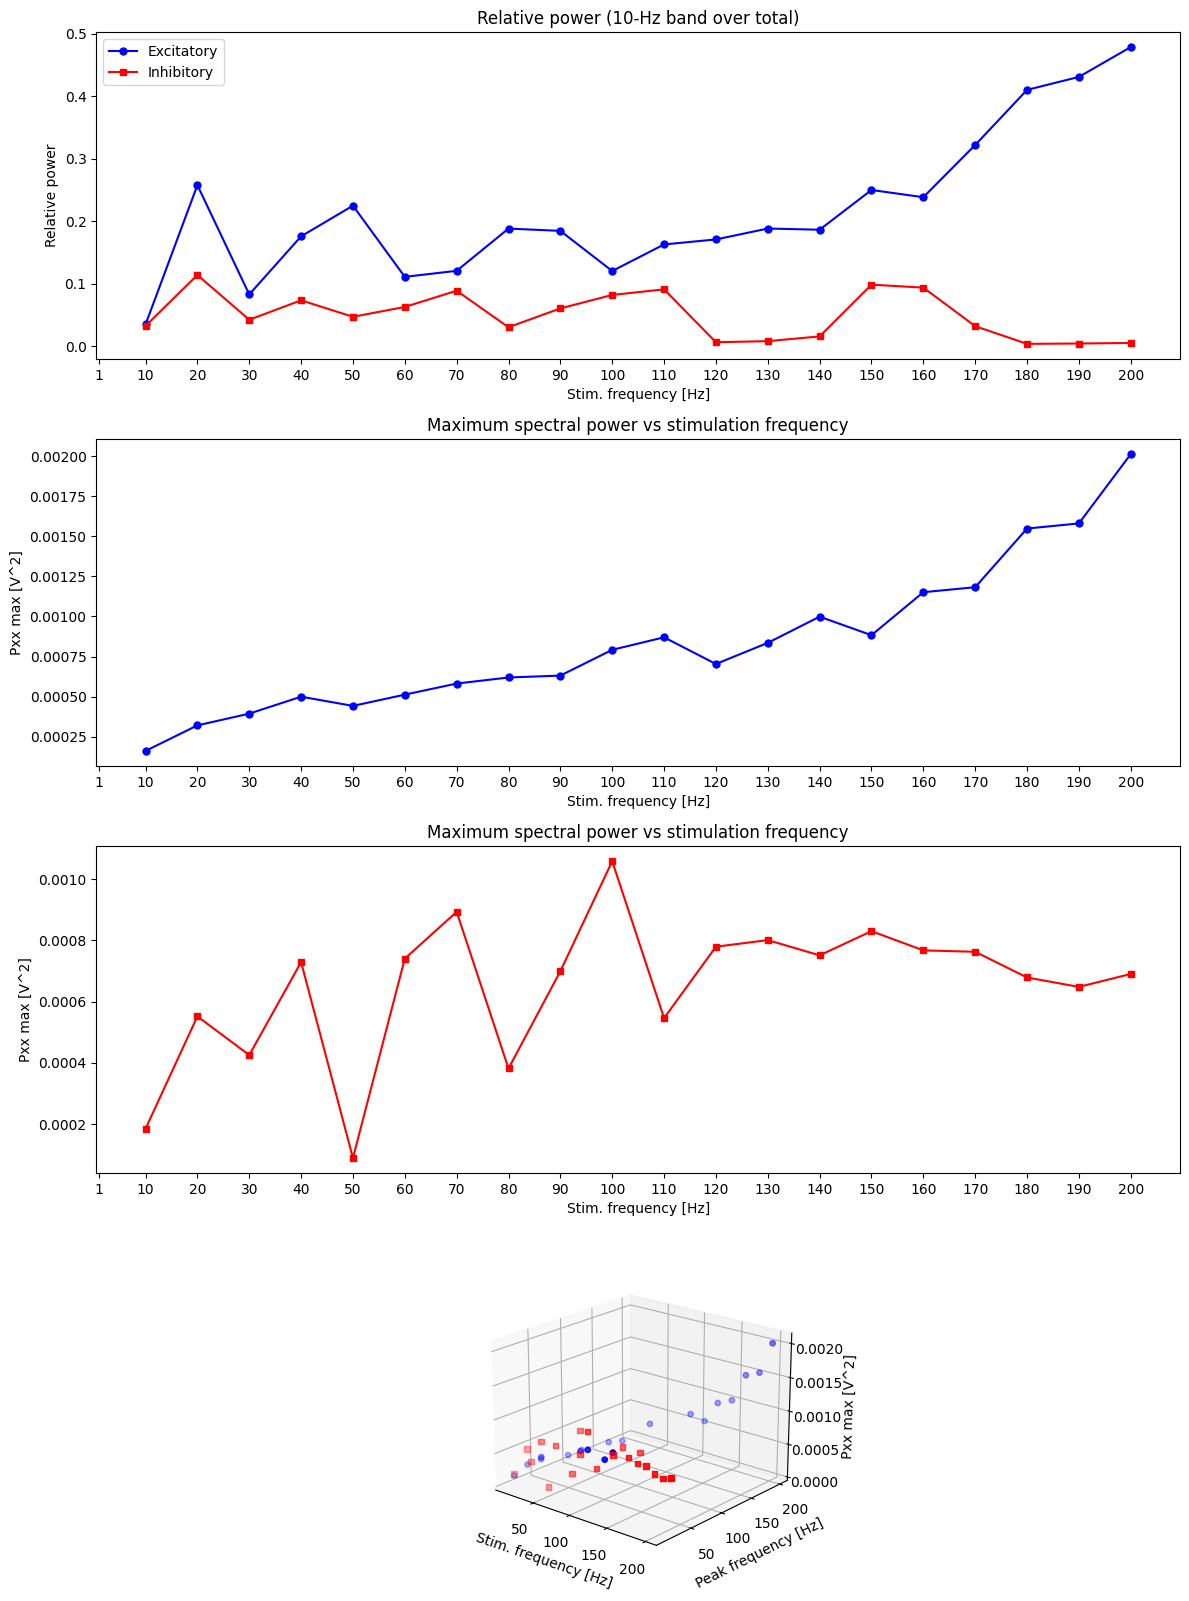

In [30]:
from mpl_toolkits.mplot3d import axes3d

fband = 10

# Pxxs
Pxxs_E = Pxxs_arr[:,0,1,:]
Pxxs_I = Pxxs_arr[:,1,1,:]
fv = Pxxs_arr[0,0,0,:]

# Calculate in a loop
peaks_E = []
peaks_I = []
vals_E = []
vals_I = []

for idx, stim_freq in enumerate(fstims_all):

    frange = stim_freq + np.round(fband/2,2) * np.array([-1,1])
    print(frange)
    
    # Check only valid ranges
    if (frange < 0).any():
        print('Out of bounds, skipping!')
        continue

    # Current stim
    tv, xstim = stim_data[idx]
    
    # Get the FRs
    tv_E, FR_E = FRs_all[idx][0]
    tv_I, FR_I = FRs_all[idx][1]

    # Normalize (for testing)
    FR_E = FR_E / N_E
    FR_I = FR_I / N_I
    
    # Calculate the Pxxs
    (f_E, Pxx_E) = welch(FR_E, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
    (f_I, Pxx_I) = welch(FR_I, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')    
    
    # Find intersecting values in frequency vector
    idx_band = np.logical_and(fv >= frange[0], fv <= frange[1])
    
    # relative power ratio
    # Pxx_tot = simpson(Pxxs_E[idx], fv)
    # Pxx_band = simpson(Pxxs_E[idx][idx_band], fv[idx_band])
    Pxx_tot = simpson(Pxx_E, f_E)
    Pxx_band = simpson(Pxx_E[idx_band], f_E[idx_band])
    vals_E += [Pxx_band / Pxx_tot]

    # Find the PSD peaks (max values)
    # fidxs = np.argmax(Pxxs_E[idx])
    # peaks_E += [[Pxxs_E[idx][fidxs], fv[fidxs], stim_freq]]
    fidxs = np.argmax(Pxx_E)
    peaks_E += [[Pxx_E[fidxs], f_E[fidxs], stim_freq]]
    
    # Pxx_tot = simpson(Pxxs_I[idx], fv)
    # Pxx_band = simpson(Pxxs_I[idx][idx_band], fv[idx_band])
    Pxx_tot = simpson(Pxx_I, f_I)
    Pxx_band = simpson(Pxx_I[idx_band], f_I[idx_band])
    vals_I += [Pxx_band / Pxx_tot]
    
    # Find the PSD peaks (max values)
    # fidxs = np.argmax(Pxxs_I[idx])
    # peaks_I += [[Pxxs_I[idx][fidxs], fv[fidxs], stim_freq]]
    fidxs = np.argmax(Pxx_I)
    peaks_I += [[Pxx_I[fidxs], f_I[fidxs], stim_freq]]
    
    # Relative power
    # print(f"Pxx [V^2]\nTotal: {Pxx_tot}; Band:{Pxx_band}; Relative power: {Pxx_band / Pxx_tot}")
    
# Plot the relative power
fig,axs = plt.subplots(4,1, figsize=(12,16))
axs[0].plot(fstims_all[1:], vals_E, 'b-o', markersize=5, label='Excitatory')
axs[0].plot(fstims_all[1:], vals_I, 'r-s', markersize=5, label='Inhibitory')
axs[0].set_title(f'Relative power ({fband}-Hz band over total)')
axs[0].set_xlabel('Stim. frequency [Hz]')
axs[0].set_ylabel('Relative power')
axs[0].legend()
axs[0].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

axs[1].plot(np.array(peaks_E)[:,2], np.array(peaks_E)[:,0], 'b-o', markersize=5)
# axs[1].plot(np.array(peaks_I)[:,2], np.array(peaks_I)[:,0], 'r-s', markersize=5)
axs[1].set_title('Maximum spectral power vs stimulation frequency')
axs[1].set_xlabel('Stim. frequency [Hz]')
# axs[1].set_ylabel('Peak frequency [Hz]')
axs[1].set_ylabel('Pxx max [V^2]')
axs[1].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

# axs[2].plot(np.array(peaks_E)[:,2], np.array(peaks_E)[:,0], 'b-o', markersize=5)
axs[2].plot(np.array(peaks_I)[:,2], np.array(peaks_I)[:,0], 'r-s', markersize=5)
axs[2].set_title('Maximum spectral power vs stimulation frequency')
axs[2].set_xlabel('Stim. frequency [Hz]')
# axs[1].set_ylabel('Peak frequency [Hz]')
axs[2].set_ylabel('Pxx max [V^2]')
axs[2].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))


axs[3].remove()
axs[3] = fig.add_subplot(4,1,4, projection='3d')
axs[3].scatter(np.array(peaks_E)[:,2], np.array(peaks_E)[:,1], np.array(peaks_E)[:,0], s=15, color='b', marker='o')
axs[3].scatter(np.array(peaks_I)[:,2], np.array(peaks_I)[:,1], np.array(peaks_I)[:,0], s=15, color='r', marker='s')
axs[3].set_xlabel('Stim. frequency [Hz]')
axs[3].set_ylabel('Peak frequency [Hz]')
axs[3].set_zlabel('Pxx max [V^2]')
axs[3].view_init(elev=20., azim=-50)


plt.tight_layout()
plt.savefig(f'figures/StimOpto/{figdir}/Pxxs_3D_maxpower_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_Istim_{I_stim}nA_tonic_{tonic_input}nA_fstim_{stim_freq}Hz_ICAN_on' + '.png')
plt.show()

0


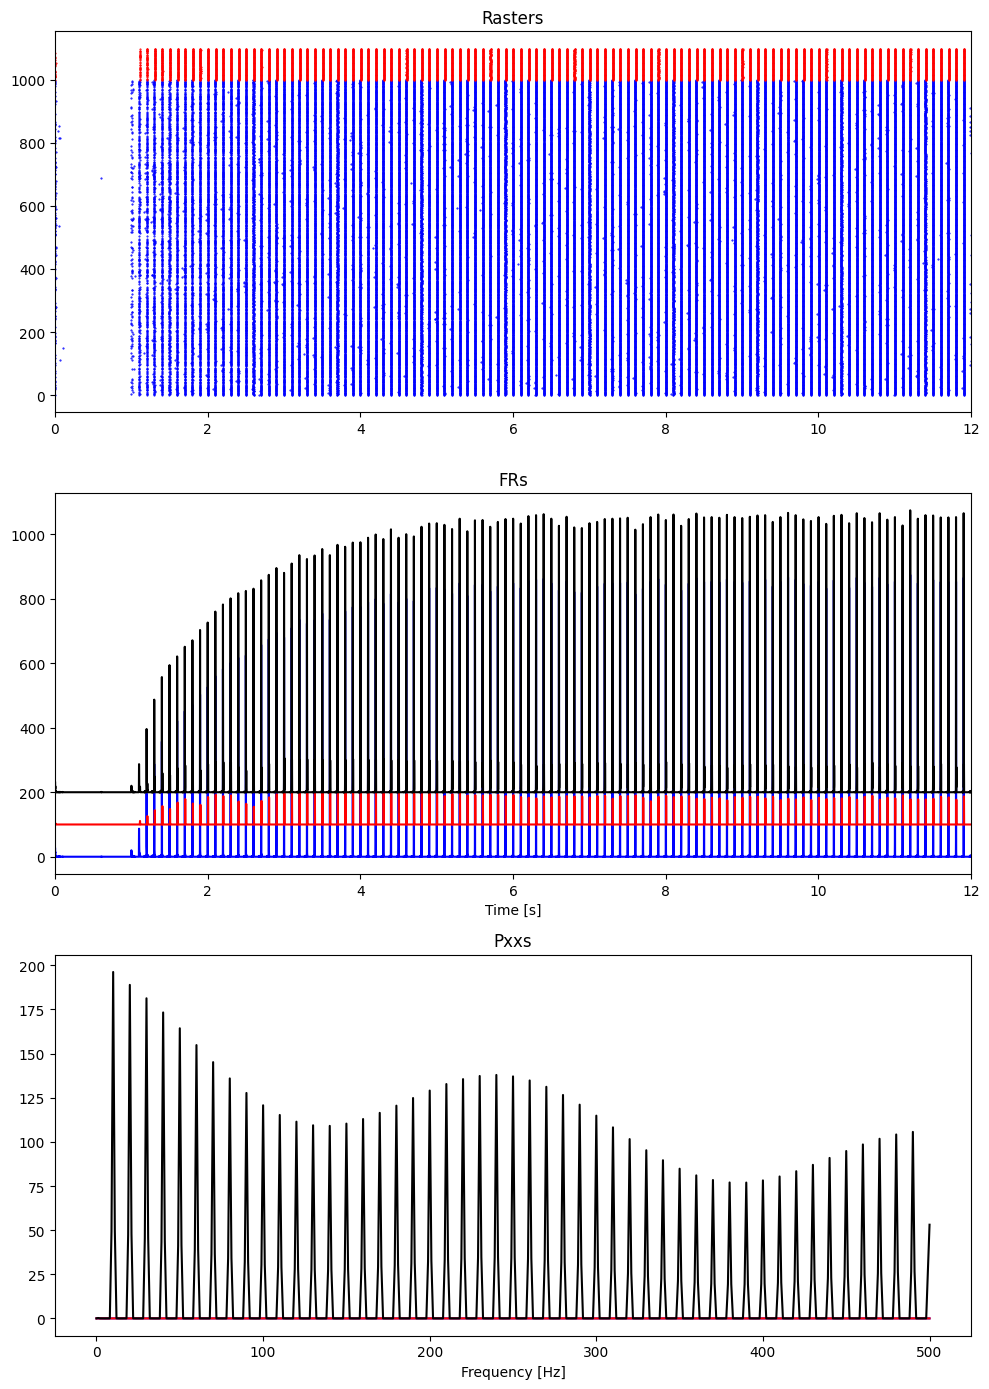

In [31]:
idx_plot = 1

# Current rasters
tE, iE = rasters_all[idx_plot][0]
tI, iI = rasters_all[idx_plot][1]

# Calculate the FRs
FR_E, tv_E = np.histogram(tE/second, bins=bin_num, range=[0,duration])
FR_I, tv_I = np.histogram(tI/second, bins=bin_num, range=[0,duration])

# Time vector adjustment
tv_E = tv_E[0:-1] + (window_size/2/second)
tv_I = tv_I[0:-1] + (window_size/2/second)

print(np.sum(np.abs(FR_E - FRs_all[idx_plot][0][1])))
             
# Load the FRs directly
tv_E, FR_E = FRs_all[idx_plot][0]
tv_I, FR_I = FRs_all[idx_plot][1]
FR_C = FR_E + FR_I

# Calculate the Pxxs
(f_E, PSD_E) = welch(FR_E, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
(f_I, PSD_I) = welch(FR_I, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
(f_C, Pxx_C) = welch(FR_C, fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')


fig,axs = plt.subplots(3,1,figsize=(10,14))

axs[0].plot(tE, iE, 'b.', markersize=1)
axs[0].plot(tI, iI+N_E, 'r.', markersize=1)
axs[0].set_xlim([0, duration])
axs[0].set_title('Rasters')

axs[1].plot(tv_E, FR_E, 'b')
axs[1].plot(tv_I, FR_I+100, 'r')
axs[1].plot(tv_E, FR_C+200, 'k')
axs[1].set_xlim([0, duration])
axs[1].set_title('FRs')
axs[1].set_xlabel('Time [s]')

axs[2].plot(f_E, Pxx_E, 'b')
axs[2].plot(f_I, Pxx_I, 'r')
axs[2].plot(f_C, Pxx_C, 'k')
axs[2].set_title('Pxxs')
axs[2].set_xlabel('Frequency [Hz]')

plt.tight_layout()
plt.show()

# Baseline vs Stim

Split the two conditions:
* Baseline: \[1-6\]s
* Light stim: \[6-11\]s

Try with/without normalizing the FRs.

Compute the spectra _separately_, then compute the relative power and the ratio Pstim / Pbaseline.


In [ ]:
from matplotlib import ticker


# Parameters for FRs
window_size = 1*ms
bin_num = int(duration/window_size)
fs_FR = 1/window_size

# Parameters for Pxxs
win_len = 1*second;
nperseg = int(win_len/second * fs_FR/Hz)
overlap_PSD = 0.99
NFFT = 2**((nperseg-1).bit_length()+1) # np.ceil(np.log2(window_width))
NFFT = nperseg

# Calculate the FRs and the Pxxs from the rasters
vals_E_base = []
vals_E_stim = []
vals_I_base = []
vals_I_stim = []
peaks_E = []
peaks_I = []
for idx, stim_freq in enumerate(fstims_all):

    frange = stim_freq + np.round(fband/2,2) * np.array([-1,1])
    print(frange)
    
    # Check only valid ranges
    if (frange < 0).any():
        print('Out of bounds, skipping!')
        continue

    # Current stim
    tv, xstim = stim_data[idx]
    
    # Get the FRs
    tv_E, FR_E = FRs_all[idx][0]
    tv_I, FR_I = FRs_all[idx][1]
    
    # Split the conditions
    idx_E_base = np.logical_and(tv_E >= 1, tv_E < stim_onset)
    idx_E_stim = np.logical_and(tv_E >= stim_onset, tv_E < duration-1)
    idx_I_base = np.logical_and(tv_E >= 1, tv_E < stim_onset)
    idx_I_stim = np.logical_and(tv_I >= stim_onset, tv_I < duration-1)
    
    # Calculate the Pxxs
    (f_E_base, Pxx_E_base) = welch(FR_E[idx_E_base], fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
    (f_E_stim, Pxx_E_stim) = welch(FR_E[idx_E_stim], fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
    (f_I_base, Pxx_I_base) = welch(FR_I[idx_I_base], fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')
    (f_I_stim, Pxx_I_stim) = welch(FR_I[idx_I_stim], fs_FR/Hz, nperseg=nperseg, nfft=NFFT, noverlap=round(nperseg*overlap_PSD), scaling='spectrum')

    # Relative power computation
    fv = f_E_base
    
    # Find the PSD peaks (max values)
    fidxs = np.argmax(Pxx_E_stim)
    peaks_E += [[Pxx_E_stim[fidxs], fv[fidxs], stim_freq]]
    fidxs = np.argmax(Pxx_I_stim)
    peaks_I += [[Pxx_I_stim[fidxs], fv[fidxs], stim_freq]]

    # Find intersecting values in frequency vector
    idx_band = np.logical_and(fv >= frange[0], fv <= frange[1])

    # relative power ratio
    # Pxx_tot = simpson(Pxx_E_base, fv)
    Pxx_tot = simpson(Pxxs_E[idx], fv)
    Pxx_band = simpson(Pxx_E_base[idx_band], fv[idx_band])
    vals_E_base += [Pxx_band / Pxx_tot]
    # Pxx_tot = simpson(Pxx_E_stim, fv)
    Pxx_stim = simpson(Pxx_E_stim[idx_band], fv[idx_band])
    vals_E_stim += [Pxx_stim / Pxx_tot]

    # Pxx_tot = simpson(Pxx_I_base, fv)
    Pxx_tot = simpson(Pxxs_I[idx], fv)
    Pxx_band = simpson(Pxx_I_base[idx_band], fv[idx_band])
    vals_I_base += [Pxx_band / Pxx_tot]
    # Pxx_tot = simpson(Pxx_I_stim, fv)
    Pxx_stim = simpson(Pxx_I_stim[idx_band], fv[idx_band])
    vals_I_stim += [Pxx_stim / Pxx_tot]

    
# Plot the relative power
fig,axs = plt.subplots(4,1, figsize=(12,16))
axs[0].plot(fstims_all[1:], np.divide(vals_E_stim, vals_E_base), 'b-o', markersize=5, label='Excitatory')
axs[0].plot(fstims_all[1:], np.divide(vals_I_stim, vals_I_base), 'r-s', markersize=5, label='Inhibitory')
axs[0].set_title('Pxx_stim / Pxx_base')
axs[0].set_xlabel('Stim. frequency [Hz]')
axs[0].set_ylabel('Relative power')
axs[0].legend()
axs[0].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

axs[1].plot(fstims_all[1:], vals_E_stim, 'b-o', markersize=5)
axs[1].plot(fstims_all[1:], vals_I_stim, 'r-s', markersize=5)
axs[1].set_title('Relative power during stim. (10-Hz band over total)')
axs[1].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

axs[2].plot(fstims_all[1:], vals_E_base, 'b-o', markersize=5)
axs[2].plot(fstims_all[1:], vals_I_base, 'r-s', markersize=5)
axs[2].set_title('Relative power during baseline (10-Hz band over total)')
axs[2].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

axs[3].plot(np.array(peaks_E)[:,2], np.array(peaks_E)[:,0], 'b-o', markersize=5)
axs[3].plot(np.array(peaks_I)[:,2], np.array(peaks_I)[:,0], 'r-s', markersize=5)
axs[3].set_title('Maximum spectral power vs stimulation frequency')
axs[3].set_xlabel('Stim. frequency [Hz]')
# axs[1].set_ylabel('Peak frequency [Hz]')
axs[3].set_ylabel('Pxx max [V^2]')
axs[3].xaxis.set_major_locator(ticker.FixedLocator(fstims_all))

plt.tight_layout()
plt.savefig(f'figures/StimOpto/{figdir}/Pxxs_stim_vs_base_maxpower_stim_E_{stim_E}_stim_I_{stim_I}_tonic_E_{tonic_E}_tonic_I_{tonic_I}_Istim_{I_stim}nA_tonic_{tonic_input}nA_fstim_{stim_freq}Hz_ICAN_on' + '.png')
plt.show()

In [ ]:
plt.plot(fv[idx_band], Pxx_E_stim[idx_band])
plt.show()